# Alternative Integrated i.i.d. Noise model

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error


In [12]:
# Load the data
gas_price_data = pd.read_csv('resources/gas_price_data_1year.csv')

In [13]:
gas_price_data.head()

,timestamp,gas_price
0,2022-06-01 11:03:52,63239618198
1,2022-06-01 12:03:48,68281963048
2,2022-06-01 13:08:25,121007946512
3,2022-06-01 14:07:45,126156205023
4,2022-06-01 15:10:50,67510279000


In [91]:
# Convert the 'timestamp' column to datetime
gas_price_data['timestamp'] = pd.to_datetime(gas_price_data['timestamp'])

# Set the 'timestamp' column as the index
gas_price_df = gas_price_data.set_index('timestamp')

In [92]:
gas_price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2022-06-01 11:03:52 to 2023-05-20 15:50:35
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   gas_price  8760 non-null   int64
dtypes: int64(1)
memory usage: 136.9 KB


In [93]:
display(gas_price_df.head(10))
gas_price_df.tail(10)

,gas_price
timestamp,
2022-06-01 11:03:52,63239618198
2022-06-01 12:03:48,68281963048
2022-06-01 13:08:25,121007946512
2022-06-01 14:07:45,126156205023
2022-06-01 15:10:50,67510279000
2022-06-01 16:15:23,32404767035
2022-06-01 17:18:36,31681542751
2022-06-01 18:28:45,63240093401
2022-06-01 19:33:58,41244724759


,gas_price
timestamp,
2023-05-20 07:26:23,36167651916
2023-05-20 08:22:11,42579332023
2023-05-20 09:17:47,36887580795
2023-05-20 10:13:23,42755192159
2023-05-20 11:09:35,34687802687
2023-05-20 12:05:35,29684795277
2023-05-20 13:02:35,31417792342
2023-05-20 13:58:35,31031853696
2023-05-20 14:54:23,28188597658


### Step 3: Data Visualization

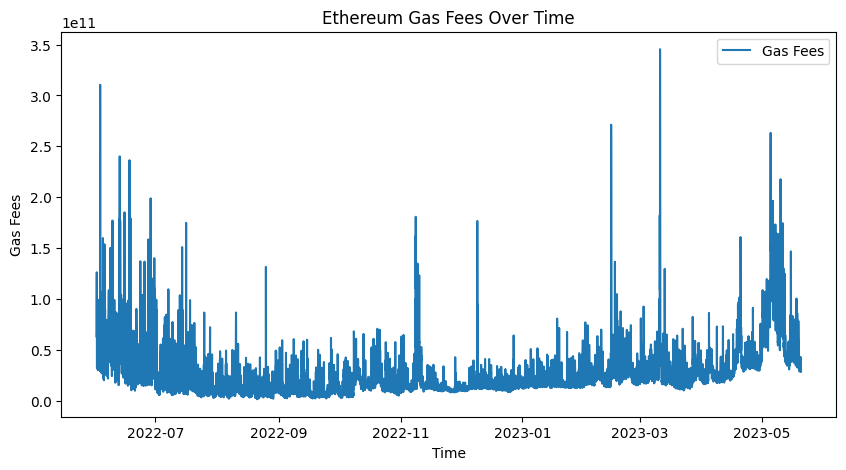

In [94]:
# Data Visualization
def visualize_data(df, gas_fees_col):
    """
    This function visualizes the data.
    Parameters: 
        df (pandas.DataFrame): The prepared data as a pandas DataFrame
        gas_fees_col (str): The name of the gas fees column
    """
    # Plotting the gas fees over time
    plt.figure(figsize=(10,5))
    plt.plot(df[gas_fees_col], label='Gas Fees')
    plt.title('Ethereum Gas Fees Over Time')
    plt.xlabel('Time')
    plt.ylabel('Gas Fees')
    plt.legend()
    plt.show()

# Visualize the data
visualize_data(gas_price_df, 'gas_price')

In [ ]:
# Define a split point for 80% of the data
split_point = int(len(gas_price_df) * 0.8)
# Split the data into training and test sets
train = gas_price_df.iloc[:split_point]
test = gas_price_df.iloc[split_point:]

In [ ]:
# Calculate the rolling mean of the training set over a 7-day window
train['rolling_mean'] = train['gas_price'].rolling(window=7).mean()

# Calculate the iid noise by subtracting the rolling mean from the actual values
train['iid_noise'] = train['gas_price'] - train['rolling_mean']

In [100]:
def rolling_forecast_iid(train, test):
    # Initialize an empty Series to store the forecast
    forecast = pd.Series(index=test.index)

    # Concatenate the train and test data
    all_data = pd.concat([train, test])

    for i in range(len(train), len(all_data)):
        # Calculate the rolling mean of the last 7 days
        rolling_mean = all_data['gas_price'].iloc[i-7:i].mean()
        
        # Calculate the iid noise by subtracting the rolling mean from the actual values
        iid_noise = all_data['gas_price'].iloc[i-7:i] - rolling_mean
        
        # Calculate the mean noise
        mean_noise = iid_noise.mean()
        
        # Generate the forecast for the next day
        forecast.iloc[i-len(train)] = all_data['gas_price'].iloc[i-1] + mean_noise

    return forecast

# Generate the rolling forecast
rolling_forecast = rolling_forecast_iid(train, test)

/var/folders/y3/0gtkw91d1jq03869hnhbpd880000gn/T/ipykernel_1329/3700541947.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  forecast = pd.Series(index=test.index)


In [101]:
# Evaluate the forecast using RMSE
rmse = sqrt(mean_squared_error(test['gas_price'], rolling_forecast))
print(f'RMSE: {rmse}')

RMSE: 12653731641.40599


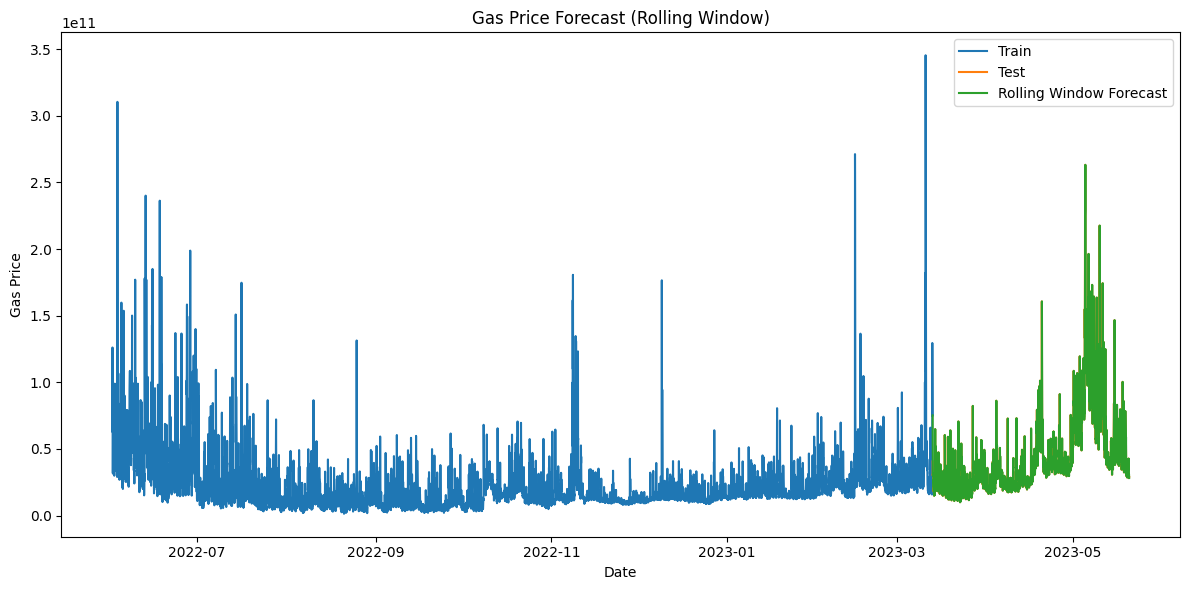

In [102]:
# Plot the actual gas prices, test set, and rolling window forecast
plt.figure(figsize=(12, 6)) 

plt.plot(train.index, train['gas_price'], label='Train')
plt.plot(test.index, test['gas_price'], label='Test')
plt.plot(rolling_forecast.index, rolling_forecast, label='Rolling Window Forecast')

plt.xlabel('Date')
plt.ylabel('Gas Price')
plt.title('Gas Price Forecast (Rolling Window)')
plt.legend()

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


RMSE: 12653731641.40599


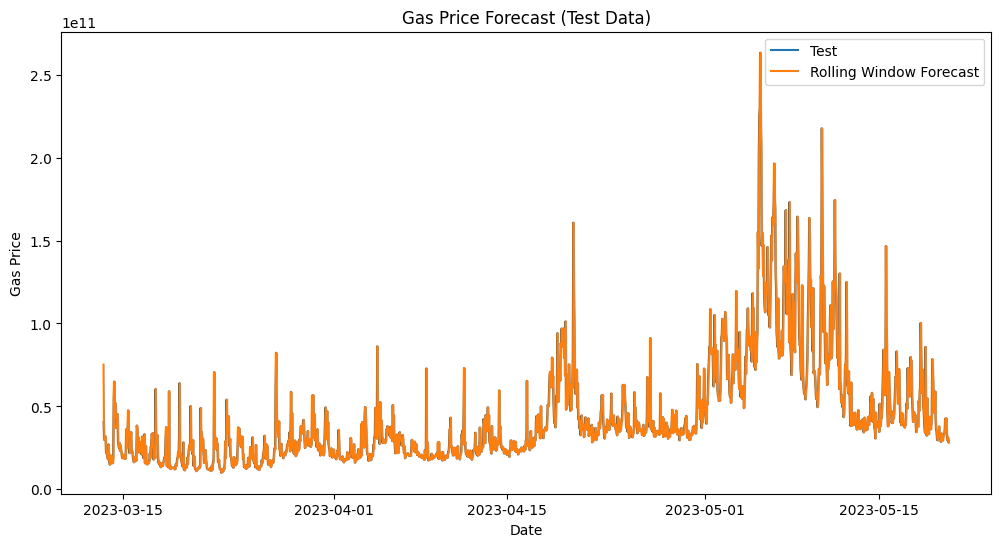

In [103]:
# Plot the test data and rolling window forecast
plt.figure(figsize=(12, 6))  # Set the size of the figure

plt.plot(test.index, test['gas_price'], label='Test')
plt.plot(test.index, rolling_forecast, label='Rolling Window Forecast')

plt.xlabel('Date')
plt.ylabel('Gas Price')
plt.title('Gas Price Forecast (Test Data)')
plt.legend()

plt.show()

### Alternative way 

In [104]:
# Calculate the series of differences (i.e., price changes) and obtain the standard deviation
std_dev = gas_price_df['gas_price'].diff().std()

In [105]:
# Generate i.i.d. noise
np.random.seed(0)  # Set seed for reproducibility
noise = np.random.normal(loc=0, scale=std_dev, size=(len(gas_price_df) - 1,))

In [106]:
# Generate integrated noise
integrated_noise = np.concatenate(([gas_price_df['gas_price'][0]], gas_price_df['gas_price'][0] + np.cumsum(noise)))

# Create a dataframe for the integrated noise
integrated_noise_df = pd.DataFrame(data=integrated_noise, index=gas_price_df.index, columns=['Integrated Noise'])

In [107]:
integrated_noise_df.head()

,Integrated Noise
timestamp,
2022-06-01 11:03:52,6.323962e+10
2022-06-01 12:03:48,9.031044e+10
2022-06-01 13:08:25,9.645118e+10
2022-06-01 14:07:45,1.114707e+11
2022-06-01 15:10:50,1.458591e+11


In [108]:
# STEP 3: Modeling and Forecasting
# Define a function for generating a 7-day forecast
def iid_noise_7day_forecast(series):
    """Generates a 7-day forecast of a time series using integrated i.i.d. noise."""
    # The forecast is simply the last value in the series plus some i.i.d. noise
    noise = np.random.normal(loc=0, scale=series.diff().std(), size=(7,))
    return series.iloc[-1] + noise.cumsum()

In [109]:
# Generate 7-day forecasts and forecast for the 8th day
forecast_8th_day = []
for i in range(7, len(gas_price_df['gas_price'])):
    seven_days_series = gas_price_df['gas_price'].iloc[i-7:i]
    forecast = iid_noise_7day_forecast(seven_days_series)
    forecast_8th_day.append(forecast[-1])

# Convert forecast to a pandas series
forecast_8th_day = pd.Series(forecast_8th_day, index=gas_price_df.index[7:])

In [110]:
# STEP 4: Benchmarking
# Calculate the forecast error
forecast_error = forecast_8th_day - gas_price_df['gas_price'].iloc[7:]

In [111]:
# Calculate the root mean square error (RMSE)
rmse = np.sqrt((forecast_error**2).mean())
print(f'RMSE: {rmse}')


RMSE: 46755024751.199684


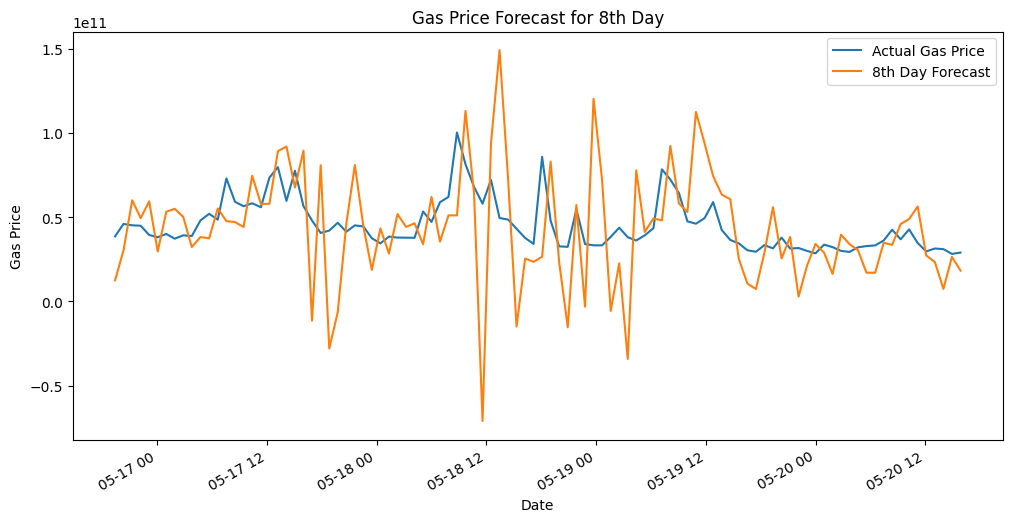

In [112]:
# Plot the actual and forecasted gas prices for last 100 data points
gas_price_df['gas_price'].iloc[-100:].plot(label='Actual Gas Price', title='Gas Price Forecast for 8th Day', figsize=(12,6))
forecast_8th_day.iloc[-100:].plot(label='8th Day Forecast')
plt.xlabel('Date')
plt.ylabel('Gas Price')
plt.legend()
plt.show()

In [113]:
def evaluate_model(gas_price_df, forecast_8th_day, withheld_data):
    """
    Evaluate the performance of the i.i.d noise model
    by calculating the forecast errors and RMSE

    """

    # Calculate the forecast errors for the 8th-day forecasts only for the last 30 days
    forecast_errors_8th_day = withheld_data - forecast_8th_day

    # Check the length of forecast_errors_8th_day and withheld_data
    min_length = min(len(forecast_errors_8th_day), len(withheld_data))

    # Cut the series to the same length
    forecast_errors_8th_day = forecast_errors_8th_day[-min_length:]
    withheld_data = withheld_data[-min_length:]

    # Remove missing values, if any, from the forecast errors
    forecast_errors_8th_day = forecast_errors_8th_day.dropna()

    # Calculate RMSE
    rmse = sqrt(mean_squared_error(withheld_data, forecast_errors_8th_day))

    return rmse

# Calculate RMSE for the 8th day forecast
rmse_8th_day = evaluate_model(gas_price_df, forecast_8th_day, withheld_data)
print('RMSE for 8th-day forecast: ', rmse_8th_day)


RMSE for 8th-day forecast:  36284876441.76175
